### AI Chess  
- Done By: Ali Massoud
- link to the BONUS part is here: https://github.com/AliMassoud/AI_Chess.git
- PLEASE read the README file ^_^

In [100]:
import pandas as pd
import glob
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from random import shuffle
from skimage.util.shape import view_as_blocks
from skimage import io, transform
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
import numpy as np
import re

In [31]:
dataset_train = glob.glob('train/*.jpeg')
dataset_test = glob.glob('test/*.jpeg')

In [32]:
train_size = 15000
test_size = 5000
shuffle(dataset_train)
shuffle(dataset_test)


In [33]:
dataset_train = dataset_train[:train_size]
dataset_test = dataset_test[:test_size]

shuffle(dataset_train)
shuffle(dataset_test)

In [34]:
dataset_train[1]

'train\\1Nb3k1-6n1-P6N-2p5-1r6-8-2pK4-6r1.jpeg'

In [35]:
def fen_from_filename(filename):
    base = os.path.basename(filename)
    return os.path.splitext(base)[0]

In [36]:
print(fen_from_filename(dataset_train[0]))
print(fen_from_filename(dataset_train[1]))
print(fen_from_filename(dataset_train[2]))

7B-r1b5-8-2b5-1P1K4-7k-3p4-8
1Nb3k1-6n1-P6N-2p5-1r6-8-2pK4-6r1
6b1-4r2P-1P1K4-b6p-5b2-Rb6-8-Q1r1N2k


In [37]:
piece_symbols = 'PRBNKQprbnkq'

#### using python-chess to explore data

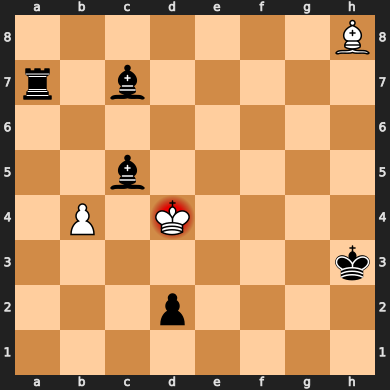

In [38]:
import chess

temp = fen_from_filename(dataset_train[0])
temp = temp.replace('-','/',7)
board = chess.Board(temp)
board

#### using matplotlib to explore the data

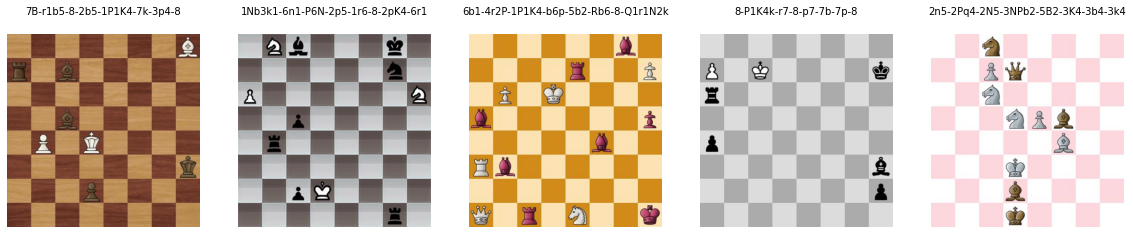

In [39]:
f, axarr = plt.subplots(1,5, figsize=(20, 30))

for i in range(0,5):
    axarr[i].set_title(fen_from_filename(dataset_train[i]), fontsize=10, pad=20)
    axarr[i].imshow(mpimg.imread(dataset_train[i]))
    axarr[i].axis('off')

## Break down the board to multiple squares manually, (I used later view_as_blocks function from scikit image)

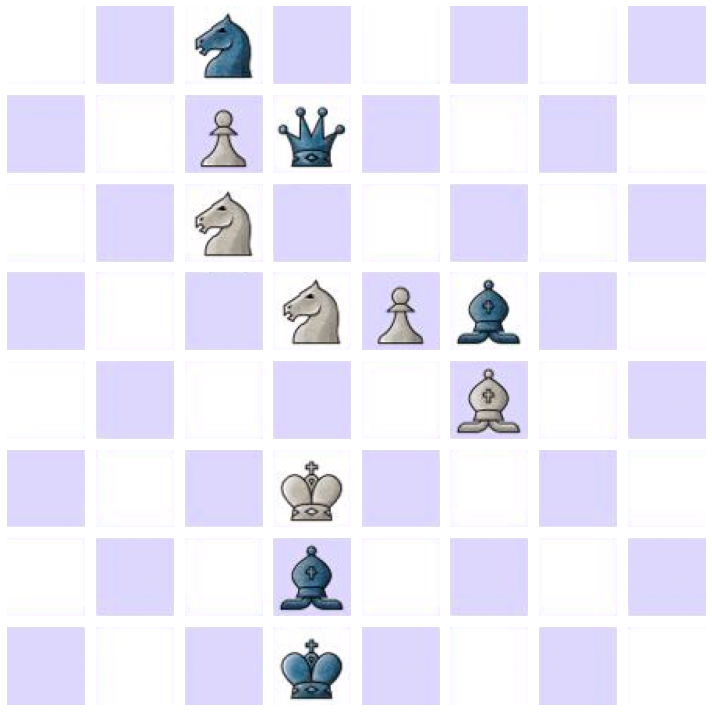

(64, 50, 50, 3)

In [40]:
def image_to_squares(img,heights,widths):
    squares = []
    for i in range(0,8):
        for j in range(0,8):
            squares.append(img[i*heights//8:i*heights//8+heights//8,j*widths//8:j*widths//8+widths//8])
    return np.array(squares)


img = cv2.imread(dataset_train[4])

image = cv2.resize(img, (400, 400))

image_normalized =(image - np.min(image)) / (np.max(image) - np.min(image))

sqaures= image_to_squares(image_normalized,400,400)
fig = plt.figure(figsize=(10, 10))
columns = 8
rows = 8
for i, img in zip(range(1, columns*rows +1),sqaures):
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')
    plt.tight_layout()
plt.show()
sqaures.shape

- **From the number of outputs below, we can see out training process won't be on the boards,
it will be on the squares of each board, since we have completely different class for each board image.**

In [43]:
labels = [fen_from_filename(img) for img in dataset_train]
set_labels = set(labels)
print("Number of labels {} is equal to number of images {}!!!".format(len(set_labels), len(dataset_train)))

Number of labels 15000 is equal to number of images 15000!!!


## Testing PCA

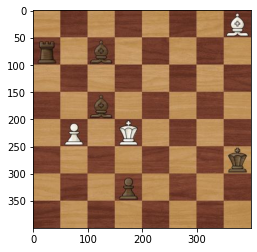

In [85]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
img = cv2.cvtColor(cv2.imread(dataset_train[0]), cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

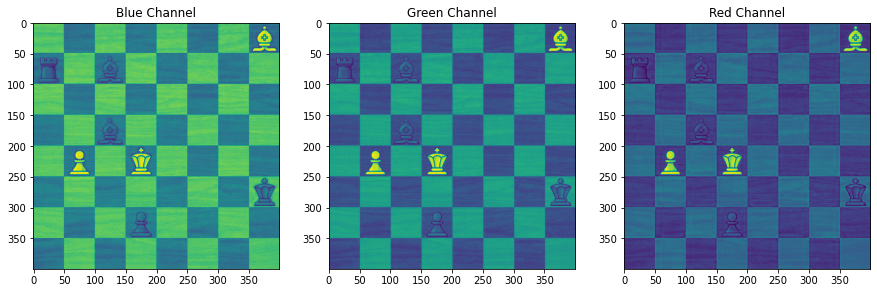

In [86]:
#Splitting into channels
blue,green,red = cv2.split(img)


fig = plt.figure(figsize = (15, 7.2)) 
fig.add_subplot(131)
plt.title("Blue Channel")
plt.imshow(blue)
fig.add_subplot(132)
plt.title("Green Channel")
plt.imshow(green)
fig.add_subplot(133)
plt.title("Red Channel")
plt.imshow(red)
plt.show()

In [87]:
blue_temp_df = pd.DataFrame(data = blue)
blue_temp_df

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,188,188,189,190,191,192,192,193,191,191,...,118,119,117,115,112,110,109,110,111,112
1,182,182,183,184,185,186,186,187,193,193,...,115,115,119,118,116,115,115,116,118,120
2,194,194,195,195,196,197,197,197,195,195,...,112,112,103,102,101,101,102,104,106,107
3,194,194,194,195,195,196,196,196,197,197,...,114,112,110,109,109,108,110,110,113,113
4,196,196,196,196,197,197,197,197,197,198,...,111,108,115,113,114,112,114,112,115,113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,97,97,97,98,98,99,100,100,101,101,...,190,190,189,188,188,188,188,188,188,189
396,97,98,99,100,100,101,101,102,105,103,...,190,190,187,188,188,188,188,188,188,187
397,100,101,101,101,101,100,99,98,106,105,...,189,190,189,189,190,190,190,190,189,189
398,99,99,100,101,100,99,98,97,99,100,...,190,190,189,190,191,192,192,191,190,189


In [88]:
df_blue = blue/255
df_green = green/255
df_red = red/255

In [95]:
pca_b = PCA(n_components=10)
pca_b.fit(df_blue)
trans_pca_b = pca_b.transform(df_blue)
pca_g = PCA(n_components=10)
pca_g.fit(df_green)
trans_pca_g = pca_g.transform(df_green)
pca_r = PCA(n_components=10)
pca_r.fit(df_red)
trans_pca_r = pca_r.transform(df_red)

In [96]:
print(f"Blue Channel : {sum(pca_b.explained_variance_ratio_)}")
print(f"Green Channel: {sum(pca_g.explained_variance_ratio_)}")
print(f"Red Channel  : {sum(pca_r.explained_variance_ratio_)}")

Blue Channel : 0.9669163567466974
Green Channel: 0.9731199576129832
Red Channel  : 0.938605384576125


In [97]:
b_arr = pca_b.inverse_transform(trans_pca_b)
g_arr = pca_g.inverse_transform(trans_pca_g)
r_arr = pca_r.inverse_transform(trans_pca_r)
print(b_arr.shape, g_arr.shape, r_arr.shape)

(400, 400) (400, 400) (400, 400)


In [98]:
img_reduced= (cv2.merge((b_arr, g_arr, r_arr)))
print(img_reduced.shape)

(400, 400, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


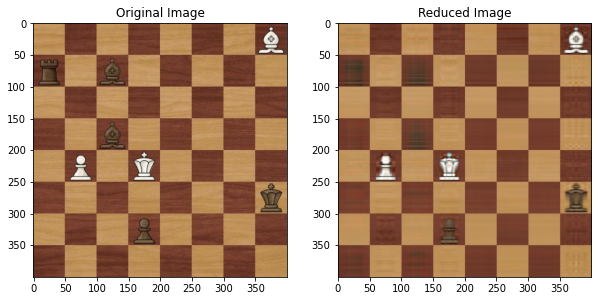

In [99]:
fig = plt.figure(figsize = (10, 7.2)) 
fig.add_subplot(121)
plt.title("Original Image")
plt.imshow(img)
fig.add_subplot(122)
plt.title("Reduced Image")
plt.imshow(img_reduced)
plt.show()

PCA seems inefficiant because in compare between the original image and the reduce one, we can see the details of the board was removed. (some black pawns almost disappeared in addition to the difficulty to differentiate between the bishop and a pawn).

### Feature Engineering & constructing th eencoder

In [92]:
def fen_from_onehot(one_hot):
    output = ''
    for j in range(8):
        for i in range(8):
            if(one_hot[j][i] == 12):
                output += ' '
            else:
                output += piece_symbols[one_hot[j][i]]
        if(j != 7):
            output += '-'

    for i in range(8, 0, -1):
        output = output.replace(' ' * i, str(i))

    return output

In [45]:
def process_image(img):
    downsample_size = 200
    square_size = int(downsample_size/8)
    img_read = io.imread(img)
    img_read = transform.resize(
      img_read, (downsample_size, downsample_size), mode='constant')
    tiles = view_as_blocks(img_read, block_shape=(square_size, square_size, 3))
    tiles = tiles.squeeze(axis=2)
    return tiles.reshape(64, square_size, square_size, 3)

In [46]:
def train_gen(features, labels, batch_size):
    for i, img in enumerate(features):
#         y = onehot_from_fen(fen_from_filename(img))
        fen = fen_from_filename(img)
        eye = np.eye(13)
        output = np.empty((0, 13))
        fen = re.sub('[-]', '', fen)

        for char in fen:
            if(char in '12345678'):
                output = np.append(
                  output, np.tile(eye[12], (int(char), 1)), axis=0)
            else:
                idx = piece_symbols.index(char)
                output = np.append(output, eye[idx].reshape((1, 13)), axis=0)
        y = output
        x = process_image(img)
        yield x, y
        
def pred_gen(features, batch_size):
    for i, img in enumerate(features):
        yield process_image(img)

- HYPERPARAMERS

In [47]:
img_rows = 25
img_cols = 25
EPOCHS = 10
BATCH_SIZE = 10
VERBOSE = 1
NB_CLASSES = 13
VALIDATION_SPLIT = 0.3

In [48]:
model = Sequential()

In [49]:
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D
model.add(Convolution2D(15, kernel_size=2, activation='relu', 
                 input_shape=(img_rows, img_cols, 3)))
model.add(MaxPool2D(2))
model.add(Convolution2D(5, kernel_size=2, activation='relu'))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(13, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 15)        195       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 15)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 5)         305       
                                                                 
 flatten (Flatten)           (None, 605)               0         
                                                                 
 dropout (Dropout)           (None, 605)               0         
                                                                 
 dense (Dense)               (None, 13)                7878      
                                                        

In [50]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy', 'Recall'])

- Creating a check point for the model

In [52]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

mdlCheck = ModelCheckpoint('best_model.h5',
                    monitor='val_loss',
                    mode='min',
                    save_best_only=True)

In [53]:
dataset_val = dataset_train[-1000:]
val_size = len(dataset_val)
dataset_train = dataset_train[:-1000]
train = train_gen(dataset_train, None, 64)
test = pred_gen(dataset_test, 64)
val = train_gen(dataset_val, None,64)

In [54]:
# for i in range(EPOCHS):
#     train = train_gen(dataset_train, None, 64)
#     val = train_gen(dataset_val, None,64)
history = model.fit(
    train_gen(dataset_train, None, 64),
    batch_size=64,
    epochs=20,
    steps_per_epoch= (train_size // BATCH_SIZE),
    validation_data=(train_gen(dataset_val, None, 64)),
    validation_steps = (val_size // BATCH_SIZE),
    callbacks=[mdlCheck]
)

Epoch 1/4
1500/1500 [==============================] - 63s 41ms/step - loss: 0.1932 - accuracy: 0.9546 - recall: 0.9283 - val_loss: 0.0340 - val_accuracy: 0.9925 - val_recall: 0.9895
Epoch 2/4
1500/1500 [==============================] - 57s 38ms/step - loss: 0.0237 - accuracy: 0.9944 - recall: 0.9921 - val_loss: 0.0109 - val_accuracy: 0.9980 - val_recall: 0.9967
Epoch 3/4
1500/1500 [==============================] - 56s 37ms/step - loss: 0.0111 - accuracy: 0.9972 - recall: 0.9966 - val_loss: 0.0027 - val_accuracy: 0.9995 - val_recall: 0.9995
Epoch 4/4
1500/1500 [==============================] - 57s 38ms/step - loss: 0.0079 - accuracy: 0.9980 - recall: 0.9978 - val_loss: 0.0030 - val_accuracy: 0.9994 - val_recall: 0.9992


In [55]:
os.getcwd()

'C:\\Users\\user\\Desktop\\Deep_Learning_Proj'

In [56]:
# model.save('best_model.h5')

In [57]:
# from tensorflow.keras.models import load_model
# model = load_model('best_model.h5')

## Model Evaluation

In [58]:
res = (model.predict(pred_gen(dataset_test, 64), steps=test_size).argmax(axis=1).reshape(-1, 8, 8))

5000/5000 [==============================] - 162s 32ms/step


In [59]:
res

array([[[12, 12, 12, ..., 12,  8,  3],
        [12, 12, 12, ..., 12, 12, 12],
        [12, 12, 12, ...,  6, 12, 12],
        ...,
        [ 4, 12, 12, ..., 10, 11, 12],
        [12, 12, 12, ..., 12, 12, 12],
        [12, 12, 12, ...,  8, 12,  9]],

       [[12, 12, 12, ..., 12, 12, 12],
        [12, 12, 12, ..., 12,  8, 12],
        [12, 12, 12, ..., 12, 12, 12],
        ...,
        [12, 12, 12, ..., 12, 11, 12],
        [ 7, 12, 12, ..., 10, 12, 12],
        [12, 12, 12, ..., 12, 12, 12]],

       [[12, 12, 12, ..., 12, 12, 12],
        [12, 12, 12, ..., 12,  6, 12],
        [12, 12, 12, ...,  6, 12, 12],
        ...,
        [12,  0, 12, ...,  8, 12, 12],
        [12, 12, 12, ..., 12, 11, 12],
        [12, 12,  8, ..., 12, 12, 12]],

       ...,

       [[12, 12, 12, ..., 12, 12, 12],
        [12, 12, 12, ..., 12, 12, 12],
        [12,  8, 12, ..., 12,  9, 12],
        ...,
        [12, 12, 12, ..., 12, 12, 12],
        [12, 12, 12, ..., 12, 12, 12],
        [ 4, 12, 12, ..., 12, 12

In [60]:
history.history['accuracy']

[0.9546250104904175,
 0.9944270849227905,
 0.9971770644187927,
 0.9980312585830688]

In [61]:
history.history['recall']

[0.9283229112625122,
 0.9921249747276306,
 0.9965729117393494,
 0.9977812767028809]

- Plotting the loss & Accuracy Evaluation

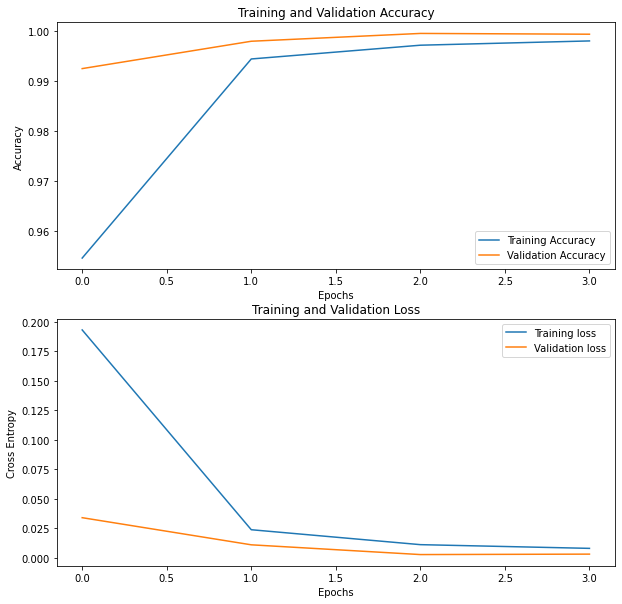

In [62]:
def std_learning_curves(history,
                        acc, val_acc,
                        loss, val_loss):
    
    plt.figure(figsize=(10,10))

    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training loss')
    plt.plot(val_loss, label='Validation loss')
    plt.legend(loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Cross Entropy')
    plt.title('Training and Validation Loss')

    plt.show()

# accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
# loss
loss = history.history['loss']
val_loss = history.history['val_loss']

# Call function to plot learning curves
std_learning_curves(history.history, 
                    acc, val_acc,
                    loss, val_loss)

- Accuracy on Test dataset

In [63]:
pred_fens = np.array([fen_from_onehot(one_hot) for one_hot in res])
test_fens = np.array([fen_from_filename(fn) for fn in dataset_test])

final_accuracy = (pred_fens == test_fens).astype(float).mean()

print("Final Accuracy: {:1.5f}%".format(final_accuracy))

Final Accuracy: 0.98260%


In [64]:
from sklearn.metrics import confusion_matrix,classification_report,f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score

print("\n----------------------Confusion Matrix-------------------")

con = confusion_matrix(test_fens, pred_fens)
con


----------------------Confusion Matrix-------------------


array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int64)

In [65]:
# import seaborn as sns
# sns.heatmap(con, annot=True)

In [66]:
print("Precison:", precision_score(test_fens, pred_fens, average='weighted'))
print("Recall:", history.history['recall'][len(history.history['recall'])-1])
print("F1 Score:", f1_score(test_fens, pred_fens, average='weighted'))
print("Accuracy:", accuracy_score(test_fens, pred_fens))

Precison: 0.9826
Recall: 0.9977812767028809
F1 Score: 0.9826
Accuracy: 0.9826


C:\Users\user\miniconda3\envs\Cvision\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [106]:
def display_with_predicted_fen(image):
    pred = model.predict(process_image(image)).argmax(axis=1).reshape(-1, 8, 8)
    fen = fen_from_onehot(pred[0])
    plt.figure(figsize=(5,5))
    imgplot = plt.imshow(mpimg.imread(image))
    plt.axis('off')
    plt.title(fen)
    plt.show()
    return fen

In [107]:
dataset_test[0]

'test\\6bN-3Rn3-4pp2-5P2-1N6-K4kq1-8-5b1n.jpeg'

2/2 [==============================] - 0s 4ms/step


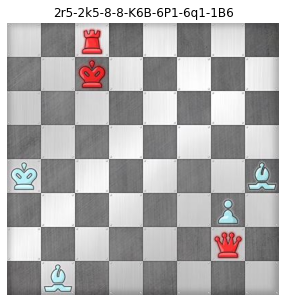

test\2r5-2k5-8-8-K6B-6P1-6q1-1B6.jpeg


In [113]:
display_with_predicted_fen(dataset_test[4000])

print(dataset_test[4000])
# display_with_predicted_fen(dataset_test[1])
# display_with_predicted_fen(dataset_test[2])

2/2 [==============================] - 0s 4ms/step


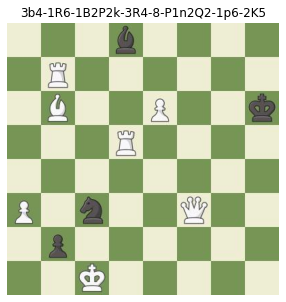

predicted BOARD : 3b4-1R6-1B2P2k-3R4-8-P1n2Q2-1p6-2K5


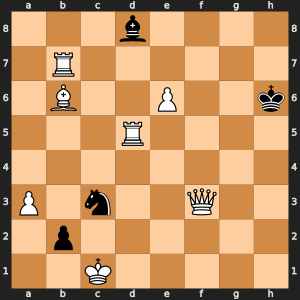

In [69]:
predicted_fen=display_with_predicted_fen(dataset_test[230])
# print(type(predicted_fen))
print("predicted BOARD :",predicted_fen)
board = chess.Board(predicted_fen.replace('-', '/'))
chess.svg.board(board, size=300)  

- there are alot of outliers 

In [70]:
mask = (pred_fens != test_fens)
predicted_outliers=pred_fens[mask]
outliers=test_fens[mask]
print("how many outliers are there?",len(outliers))

how many outliers are there? 87
